### **Computer Lab : Digit Recognition SD-TSIA211**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

5


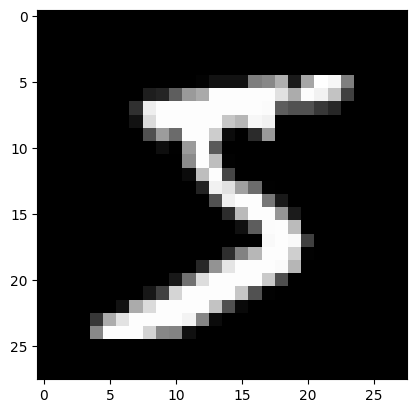

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [3]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()
uweights = model.get_weights()
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]
# what we would like to get
y_train[0:100]


Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

#### Question 4.1 

The loss fonction is the categorical cross-entroy function define by : 
 
\begin{align*}
l(y^{pred}, y^{true}) &= -\sum_{i=1}^{n} \sum_{d=0}^{9} y^{true}_{i,d} \log(y^{pred}_{i,d})\\

\end{align*}
where $y_{i,d}^{true} = 1$ if i represents a digit d and 0 otherwise.

**Question 4.1**
How many optimization variables are we going to train using this model?

Answer : il y a 784 *32 + 32 (pour les biais à l'étape 1) + 32*32 + 32 (pour les biais à l'étape 2) + 10*10 + 10  = 26506 variables à optimiser.


### **5 Stochastic gradient descent**

Question 5.1
Reusing the code provided in the basic functions file, implement stochastic gradient descent
for the resolution of the neural network model.

In [4]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()
    

2.3308477

In [5]:
def accuracy(model, X, Y):
    samples_for_evaluation = np.random.randint(0, 10000, 1000)
    logits = model(x_train[samples_for_evaluation])
    loss(y_train[samples_for_evaluation], logits).numpy()
    accuracy = np.mean(np.argmax(logits, 1) == y_train[samples_for_evaluation])
    #print('the accuracy of this model is', accuracy)
    return accuracy

In [6]:
# Stochastic gradient algorithm

# TO IMPLEMENT
def stochastic_gradient(model, X_train, Y_train, loss, batch_size, learning_rate):
    n = len(X_train)

    #mélanger les données
    indices = np.random.permutation(n)
    x_train = X_train[indices]
    y_train = Y_train[indices]
    i = 0

    objective_function = []
    iterations = []
    
    print( 'the accuracy of this model before the training is', accuracy(model, X_train, Y_train))
    print( 'the loss of this model before the training is', loss(Y_train, model(X_train)).numpy())
    
    while (i+1)*batch_size<n:

        x_train_batch = x_train[i*batch_size:(i+1)*batch_size]
        y_train_batch = y_train[i*batch_size:(i+1)*batch_size]

        with tf.GradientTape() as tape:
            logits = model(x_train_batch)  # Logits for this minibatch
            loss_value = loss(y_train_batch, logits)

        grad = tape.gradient(loss_value, model.trainable_weights)

        update = [-learning_rate/ np.sqrt(i+1) * g for g in grad]
        #update = [-learning_rate * g for g in grad]
        update_weights(model, update)
        i += 1

        if (i%300 == 0):
            a = loss(y_train, model(x_train)).numpy()
            objective_function.append(a)
            iterations.append(i)
            print( 'for the batch', i*batch_size, '/' , n, 'the loss is', a)
    ## plot objective function 
    plt.plot(objective_function)
    plt.title('Objective function')
    plt.xlabel('Iterations')
    plt.ylabel('Objective function')
    plt.legend(['Objective function'])
    plt.show()
    print( 'the accuracy of this model after the training is', accuracy(model, X_train, Y_train))
    return model, objective_function

**Question 5.2**
Run it for one pass over the data (also called one epoch) and with a learning rate that satisfies the conditions required by theory.  
Plot the objective value as a function of the iterations.  
Hint: Do not compute the objective value at each iteration, only from time to time. This is sufficient for plotting purposes and will save computing time.


the accuracy of this model before the training is 0.122
the loss of this model before the training is 2.3267334


for the batch 4800 / 60000 the loss is 2.2102046
for the batch 9600 / 60000 the loss is 2.1681986
for the batch 14400 / 60000 the loss is 2.1349401
for the batch 19200 / 60000 the loss is 2.1065264
for the batch 24000 / 60000 the loss is 2.0796976
for the batch 28800 / 60000 the loss is 2.0548754
for the batch 33600 / 60000 the loss is 2.0314891
for the batch 38400 / 60000 the loss is 2.0084183
for the batch 43200 / 60000 the loss is 1.9868181
for the batch 48000 / 60000 the loss is 1.9656427
for the batch 52800 / 60000 the loss is 1.9458936
for the batch 57600 / 60000 the loss is 1.9264214


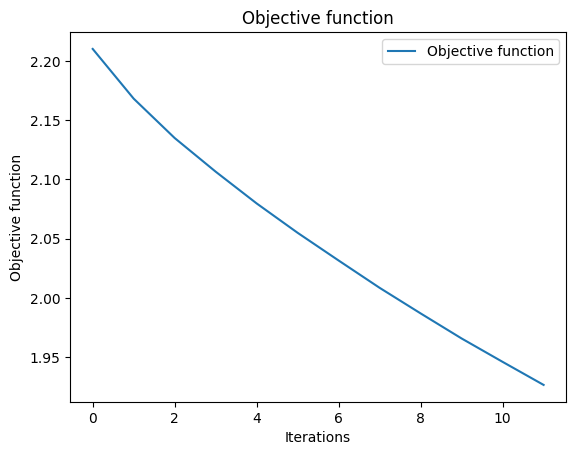

the accuracy of this model after the training is 0.451
[2.2102046, 2.1681986, 2.1349401, 2.1065264, 2.0796976, 2.0548754, 2.0314891, 2.0084183, 1.9868181, 1.9656427, 1.9458936, 1.9264214]


In [7]:
## run it over one pass over the data (also called one epoch)
# calcul du pas learning rate
model.set_weights(uweights)
learning_rate = 0.01
model, obj = stochastic_gradient(model, x_train, y_train, loss, 16, learning_rate)
print(obj)



Contraring to the theory, we observe that the accuracy is  better when the learning rate is constant and not decreasing.

### **6 Empirical risk minimization**

**Question 6.1**
Implement stochastic gradient descent for the resolution of the empirical risk minimization
problem and run it for 10 epochs

In [8]:
def stochastic_gradient_epoch(model, X_train, Y_train, loss, batch_size, learning_rate,nb_epoch):
    n = len(X_train)
    objective_function = []
    iterations = []

    print( 'the accuracy of this model before the training is', accuracy(model, X_train, Y_train))
    print( 'the loss of this model before the training is', loss(Y_train, model(X_train)).numpy())

    for k in range(nb_epoch):

        indices = np.random.permutation(n)
        x_train = X_train[indices]
        y_train = Y_train[indices]
        i = 0
        
        while (i+1)*batch_size<n:

            x_train_batch = x_train[i*batch_size:(i+1)*batch_size]
            y_train_batch = y_train[i*batch_size:(i+1)*batch_size]

            with tf.GradientTape() as tape:
                logits = model(x_train_batch)  # Logits for this minibatch
                loss_value = loss(y_train_batch, logits)

            grad = tape.gradient(loss_value, model.trainable_weights)

            update = [-learning_rate/ np.sqrt(i+1)/ batch_size * g for g in grad]
            update_weights(model, update)
            i += 1
        
        a = loss(y_train, model(x_train)).numpy()
        objective_function.append(a)
        iterations.append(k)
        
        print( 'the accuracy of this model after the epoch number', k+1,'/', nb_epoch  , 'is', accuracy(model, x_train, y_train))
        print( 'the loss of this model after the epoch number', k+1, 'is', a)
        
    ## plot objective function 
    plt.plot(objective_function)
    plt.title('Objective function')
    plt.xlabel('Iterations')
    plt.ylabel('Objective function')
    plt.legend(['Objective function'])
    plt.show()
    return model, objective_function


the accuracy of this model before the training is 0.127
the loss of this model before the training is

 2.3267334
the accuracy of this model after the epoch number 1 / 5 is 0.375
the loss of this model after the epoch number 1 is 2.021294
the accuracy of this model after the epoch number 2 / 5 is 0.562
the loss of this model after the epoch number 2 is 1.6409135
the accuracy of this model after the epoch number 3 / 5 is 0.692
the loss of this model after the epoch number 3 is 1.2442137
the accuracy of this model after the epoch number 4 / 5 is 0.724
the loss of this model after the epoch number 4 is 0.97868514
the accuracy of this model after the epoch number 5 / 5 is 0.747
the loss of this model after the epoch number 5 is 0.8209056


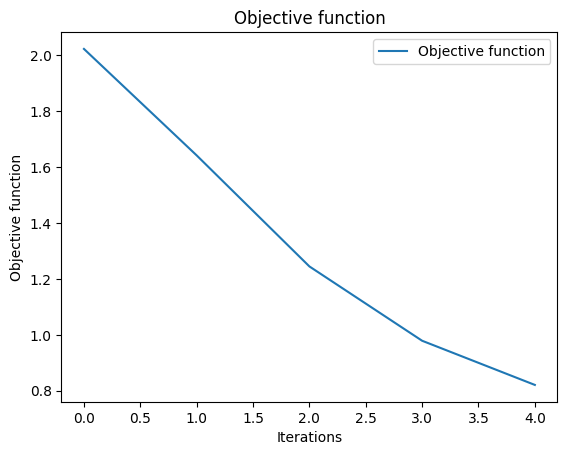

[2.021294, 1.6409135, 1.2442137, 0.97868514, 0.8209056]


In [9]:
# we increase the learning rate to 1 and the batch size to 64

model.set_weights(uweights)
model, obj = stochastic_gradient_epoch(model, x_train, y_train, loss, 64, 1, 5)
accuracy(model, x_train, y_train)
print(obj)

The objective function is really good compared to last question. The accuracy is also better.  
**We will see that the learning rate is really important since in the first question, it decreases over the iterations while in the second question, it is constant.**

### **Test part** 


In [10]:
## We want to test the difference of the learning rate, here the learning rate is 0.01 and decrease with the number of iterations

def stochastic_gradient_test(model, X_train, Y_train, loss, batch_size, learning_rate):
    n = len(X_train)
    indices = np.random.permutation(n)
    x_train = X_train[indices]
    y_train = Y_train[indices]
    i = 0

    while (i+1)*batch_size<n:

        x_train_batch = x_train[i*batch_size:(i+1)*batch_size]
        y_train_batch = y_train[i*batch_size:(i+1)*batch_size]

        with tf.GradientTape() as tape:
            logits = model(x_train_batch)  # Logits for this minibatch
            loss_value = loss(y_train_batch, logits)

        grad = tape.gradient(loss_value, model.trainable_weights)

        update = [-learning_rate/ np.sqrt(i+1) * g for g in grad]
        update_weights(model, update)
        i += 1
    return model

In [15]:
def stochastic_gradient_epoch_test(model, X_train, Y_train, loss, batch_size, learning_rate,nb_epoch):
    n = len(X_train)
    objective_function = []
    iterations = []

    print( 'the accuracy of this model before the training is', accuracy(model, X_train, Y_train))
    print( 'the loss of this model before the training is', loss(Y_train, model(X_train)).numpy())

    for k in range(nb_epoch):

        stochastic_gradient_test(model, X_train, Y_train, loss, batch_size, learning_rate)
        a = loss(y_train, model(x_train)).numpy()
        objective_function.append(a)
        iterations.append(k)
        
        print( 'the accuracy of this model after the epoch number', k+1,'/', nb_epoch  , 'is', accuracy(model, x_train, y_train))
        print( 'the loss of this model after the epoch number', k+1,'/', nb_epoch, 'is', a, '\n')
        
    ## plot objective function 
    plt.plot(objective_function)
    plt.title('Objective function')
    plt.xlabel('Iterations')
    plt.ylabel('Objective function')
    plt.legend(['Objective function'])
    plt.show()
    return model, objective_function

the accuracy of this model before the training is 0.106


the loss of this model before the training is 2.3267334
the accuracy of this model after the epoch number 1 / 5 is 0.401
the loss of this model after the epoch number 1 / 5 is 2.0480952 

the accuracy of this model after the epoch number 2 / 5 is 0.534
the loss of this model after the epoch number 2 / 5 is 1.7152563 

the accuracy of this model after the epoch number 3 / 5 is 0.65
the loss of this model after the epoch number 3 / 5 is 1.3397069 

the accuracy of this model after the epoch number 4 / 5 is 0.704
the loss of this model after the epoch number 4 / 5 is 1.0573245 

the accuracy of this model after the epoch number 5 / 5 is 0.768
the loss of this model after the epoch number 5 / 5 is 0.8820161 



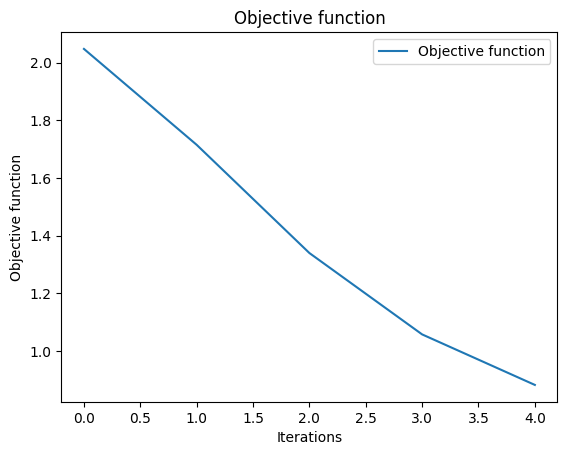

[2.0480952, 1.7152563, 1.3397069, 1.0573245, 0.8820161]


In [11]:

model.set_weights(uweights)
model, obj = stochastic_gradient_epoch_test(model, x_train, y_train, loss, 32, 0.01, 5)
print(obj)

In [12]:
##" Here the step become constant to 0.01
## test 

def stochastic_gradient_test2(model, X_train, Y_train, loss, batch_size, learning_rate):
    n = len(X_train)
    indices = np.random.permutation(n)
    x_train = X_train[indices]
    y_train = Y_train[indices]
    i = 0

    while (i+1)*batch_size<n:

        x_train_batch = x_train[i*batch_size:(i+1)*batch_size]
        y_train_batch = y_train[i*batch_size:(i+1)*batch_size]

        with tf.GradientTape() as tape:
            logits = model(x_train_batch)  # Logits for this minibatch
            loss_value = loss(y_train_batch, logits)

        grad = tape.gradient(loss_value, model.trainable_weights)
        
        update = [-learning_rate * g for g in grad]
        update_weights(model, update)
        i += 1
    return model



In [16]:
def stochastic_gradient_epoch_test2(model, X_train, Y_train, loss, batch_size, learning_rate,nb_epoch):
    n = len(X_train)
    objective_function = []
    iterations = []

    print( 'the accuracy of this model before the training is', accuracy(model, X_train, Y_train))
    print( 'the loss of this model before the training is', loss(Y_train, model(X_train)).numpy())

    for k in range(nb_epoch):

        stochastic_gradient_test2(model, X_train, Y_train, loss, batch_size, learning_rate)
        a = loss(y_train, model(x_train)).numpy()
        objective_function.append(a)
        iterations.append(k)
        
        print( 'the accuracy of this model after the epoch number', k+1,'/', nb_epoch  , 'is', accuracy(model, x_train, y_train))
        print( 'the loss of this model after the epoch number', k+1, '/', nb_epoch,  'is', a , '\n')
        
    ## plot objective function 
    plt.plot(objective_function)
    plt.title('Objective function')
    plt.xlabel('Iterations')
    plt.ylabel('Objective function')
    plt.legend(['Objective function'])
    plt.show()
    return model, objective_function


the accuracy of this model before the training is 0.129


the loss of this model before the training is 2.3267334
the accuracy of this model after the epoch number 1 / 5 is 0.899
the loss of this model after the epoch number 1 / 5 is 0.37120703 

the accuracy of this model after the epoch number 2 / 5 is 0.927
the loss of this model after the epoch number 2 / 5 is 0.29229355 

the accuracy of this model after the epoch number 3 / 5 is 0.931
the loss of this model after the epoch number 3 / 5 is 0.252829 

the accuracy of this model after the epoch number 4 / 5 is 0.93
the loss of this model after the epoch number 4 / 5 is 0.22643648 

the accuracy of this model after the epoch number 5 / 5 is 0.948
the loss of this model after the epoch number 5 / 5 is 0.20785366 



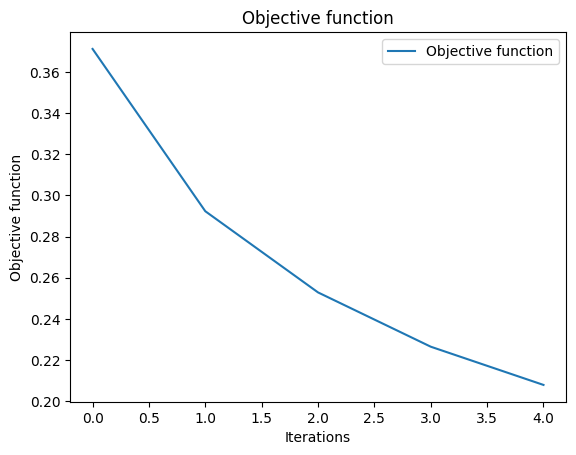

[0.37120703, 0.29229355, 0.252829, 0.22643648, 0.20785366]


In [13]:
model.set_weights(uweights)
model, obj = stochastic_gradient_epoch_test2(model, x_train, y_train, loss, 32, 0.01, 5)
print(obj)

**We can cleary see that the accuracy is better when the learning rate is constant and not decreasing.**  
**The loss of this model is also better.**  
We can also see that one step of the gradient descent is enough to get 90% of accuracy.


##### **Question 6.2**
According to you, what is the advantage of such a scheme?

Answer : 

### **Evaluation of the model**

**Question 7.1**
Evaluate the accuracy of the model on the training set and on the test set.

In [22]:
## we increase the number of epoch to 10 and the batch size to 64 so that it doesn't take too much time to compute

x_test, y_test = test_data[0].reshape(-1,784).astype(float) / 255, test_data[1]
accur_test, accur_train = accuracy(model, x_test, y_test), accuracy(model, x_train, y_train)

print('the accuracy of this model on the test set is', accur_test)
print('the accuracy of this model on the train set is', accur_train)



the accuracy of this model on the test set is 0.944
the accuracy of this model on the train set is 0.949
